In [1]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
from datetime import datetime

# Data extraction & Returns Overview

In [2]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol , start_date , end_date)
df = strat_mgr.df.copy()

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2023-10-04,27429.074219,27826.658203,27248.105469,27799.394531,11143355314,0.013468,0.021233,3.217869
2023-10-05,27798.646484,28091.861328,27375.601562,27415.912109,11877253670,-0.013795,0.026164,3.159110
2023-10-06,27412.123047,28252.537109,27215.552734,27946.597656,13492391599,0.019357,0.038103,3.239645
2023-10-07,27946.781250,28028.091797,27870.423828,27968.839844,6553044316,0.000796,0.005657,3.243450
2023-10-08,27971.677734,28102.169922,27740.662109,27935.089844,7916875290,-0.001207,0.013032,3.238235


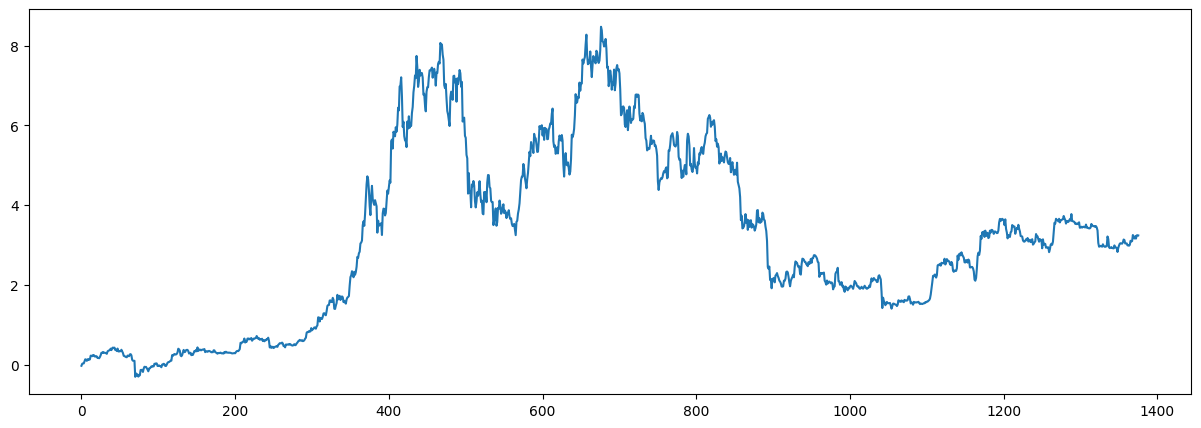

In [3]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

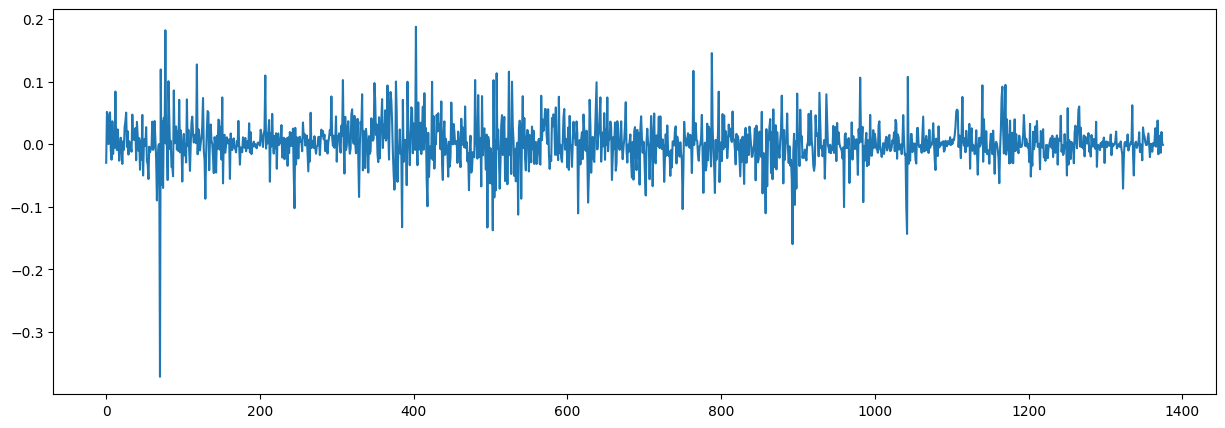

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Returns"].values)
plt.show()

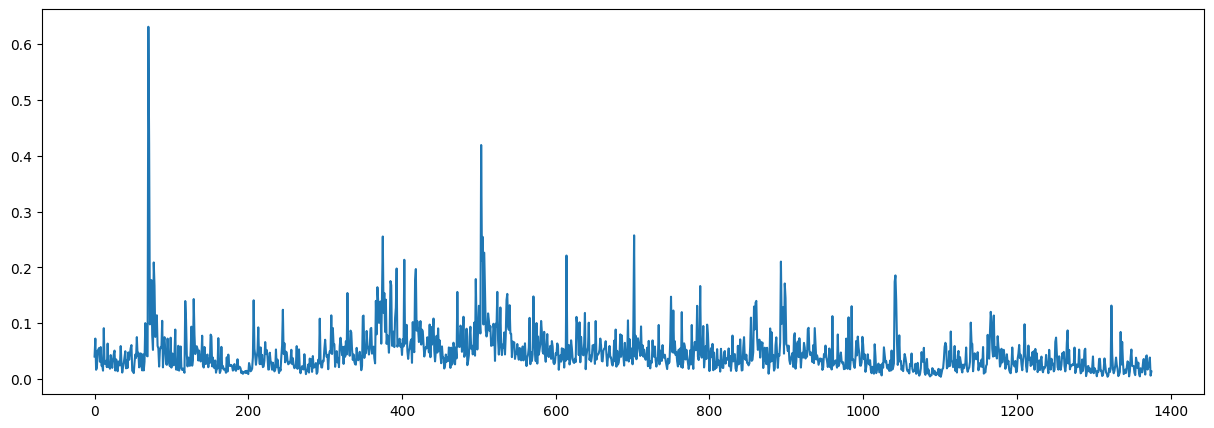

In [5]:
fig = plt.figure(figsize=(15,5))
plt.plot(df["Range"].values)
plt.show()

# Feature Engineering - Feature Expantion

In [6]:
df_fe = df.copy()

# Indicators

In [7]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi

df_fe["RSI_Return"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [8]:
# Add moving averages
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [9]:
# Day of the week
df_fe["DOW"] = df_fe.index.dayofweek

In [10]:
# Rolling Cumalitive returns
df_fe["Rolling_rets"] = df_fe["Returns"].rolling(window=30).sum()

In [11]:
# Rolling Cumalitive Range
df_fe["AVG_Range"] = df_fe["Range"].rolling(window=30).mean()

## Time Intervals

In [12]:
# Add Time Intervals
time_steps = [1,2]
time_features = ["Returns", "Range", "Rolling_rets"]
for ts in time_steps:
    for tf in time_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

### Feature Engineering

In [13]:
# Correct for stationarity
df_stationary = df_fe.copy()

df_stationary[["Open","High","Low","Volume"]] = df_stationary[["Open","High","Low","Volume"]].pct_change()

# ASSES DATA FOR ML READINESS

In [14]:
# Check for NaN
df_stationary = df_stationary.dropna()

In [15]:
# Check for inf values
dfobj = df_stationary.isin([np.inf,-np.inf])
count = np.isinf(dfobj).values.sum()

In [16]:
# Check for non numerical objects
df_stationary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2020-02-02 to 2023-10-08
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1345 non-null   float64
 1   High             1345 non-null   float64
 2   Low              1345 non-null   float64
 3   Close            1345 non-null   float64
 4   Volume           1345 non-null   float64
 5   Returns          1345 non-null   float64
 6   Range            1345 non-null   float64
 7   Bench_C_Rets     1345 non-null   float64
 8   RSI              1345 non-null   float64
 9   RSI_Return       1345 non-null   float64
 10  MA_12            1345 non-null   float64
 11  MA_21            1345 non-null   float64
 12  DOW              1345 non-null   int64  
 13  Rolling_rets     1345 non-null   float64
 14  AVG_Range        1345 non-null   float64
 15  Returns_T1       1345 non-null   float64
 16  Range_T1         1345 non-null   float64
 

In [17]:
# describe dataframe
df_stationary.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,MA_21,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2
count,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,...,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000,1345.000000
mean,0.001462,0.001284,0.001504,28864.113100,0.041008,0.001457,0.047127,3.242461,52.118995,1.005159,...,28727.418883,3.002230,0.045100,0.047238,0.001461,0.047127,0.045272,0.001448,0.047146,0.045426
std,0.035566,0.030727,0.036523,15240.215099,0.330543,0.035507,0.040627,2.194897,13.807294,0.104611,...,15171.606842,2.001672,0.204813,0.020797,0.035507,0.040627,0.204936,0.035511,0.040613,0.205031
min,-0.365924,-0.263712,-0.364062,4970.788086,-0.869188,-0.371695,0.003596,-0.305805,14.037826,0.456113,...,5984.235073,0.000000,-0.613606,0.015756,-0.371695,0.003596,-0.613606,-0.371695,0.003596,-0.613606
25%,-0.013583,-0.011769,-0.011030,17088.660156,-0.145844,-0.013795,0.023090,1.566435,42.507172,0.953251,...,17014.588635,1.000000,-0.085107,0.032947,-0.013795,0.023090,-0.085107,-0.013802,0.023150,-0.085107
50%,0.000370,-0.000505,0.002480,26930.638672,-0.005723,0.000313,0.038051,3.087965,50.645636,1.000858,...,26938.564453,3.000000,0.023127,0.044420,0.000316,0.038051,0.023127,0.000313,0.038051,0.023127
75%,0.016641,0.013245,0.014982,39773.828125,0.169998,0.016571,0.057534,4.985288,60.931598,1.047815,...,40278.502418,5.000000,0.188721,0.055176,0.016571,0.057534,0.190806,0.016571,0.057534,0.191355
max,0.187677,0.187159,0.247892,67566.828125,5.439003,0.187465,0.631387,8.471219,90.719434,1.915829,...,63016.876488,6.000000,0.818827,0.118472,0.187465,0.631387,0.818827,0.187465,0.631387,0.818827


## SAVE DATAFRAME

In [18]:
# use or create folder to save data
import os

folder_name = 'data'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"'{folder_name}' has been created")
else:
    print(f"'{folder_name}' already exists")

'data' already exists


In [19]:
# save dataframe into csv
df_stationary.to_csv(f"{folder_name}/{symbol}.csv")